In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

C:\Users\Sagar\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 1.1 Reading Data

In [4]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [5]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [6]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 preprocessing of `project_subject_categories`

In [7]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [8]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [9]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [10]:

project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [11]:
#### 1.4.2.3 Using Pretrained Models: TFIDF weighted W2V

In [12]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)

My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [13]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [15]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [16]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [18]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:56<00:00, 1921.67it/s]


In [19]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

In [20]:
# similarly you can preprocess the titles also
print(project_data['project_title'].values[0])
print('-'*100)
print(project_data['project_title'].values[289])
print('-'*100)
print(project_data['project_title'].values[1090])
print('-'*100)
print(project_data['project_title'].values[7])
print('-'*100)
print(project_data['project_title'].values[15000])
print('-'*100)
print(project_data['project_title'].values[15468])

Educational Support for English Learners at Home
----------------------------------------------------------------------------------------------------
Learning to Shred!
----------------------------------------------------------------------------------------------------
Coding: Bee-Bots to Discover Computer Science
----------------------------------------------------------------------------------------------------
It's the 21st Century
----------------------------------------------------------------------------------------------------
\r\nThe \"i\" Classroom
----------------------------------------------------------------------------------------------------
Mission: Target Learning


In [21]:
# let's decontract the titles by using the decontracted fuinction defined above
decon = decontracted(project_data['project_title'].values[7])
print(decon)

It is the 21st Century


In [22]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sen = project_data['project_title'].values[15000].replace('\\r',' ')
sen = sen.replace('\\"',' ')
sen = sen.replace('\\n',' ')
print(sen)

  The  i  Classroom


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', project_data['project_title'].values[15468])
print(sent)

Mission Target Learning


In [24]:
#let's combine all above and apply to all the data points
preprocessed_title = []
for sentances in tqdm(project_data['project_title'].values):
    sentance = decontracted(sentances)
    sentance = sentance.replace("\\r",' ')
    sentance = sentance.replace("\\n",' ')
    sentance = sentance.replace('\\"',' ')
    sentance = re.sub('[^A-Za-z0-9]+',' ',sentance)
    
    sentance = ' '.join(e for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_title.append(sentance.lower().strip())

100%|██████████| 109248/109248 [00:02<00:00, 41412.32it/s]


In [25]:
preprocessed_title[20000]

'need move input'

## 1.5 Preparing data for models

In [26]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

In [27]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

__ Computing Sentiment Scores__

In [28]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = []
for es in tqdm(preprocessed_essays):
    ss.append(sid.polarity_scores(es))

senti_scores = pd.DataFrame(ss)

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

100%|██████████| 109248/109248 [02:59<00:00, 607.86it/s]


# Assignment 8: DT

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use gridsearch cv or randomsearch cv)/simple cross validation data(you can write your own for loops refer sample solution)</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points`</li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
   <li><b>Task 2: </b>For this task consider set-1 features. Select all the features which are having non-zero feature importance.You can get the feature importance using  'feature_importances_` 
   (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), discard the all other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM), you need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3<br>
  Note: when you want to find the feature importance make sure you don't use max_depth parameter keep it None.
  </li>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Decision Tree </h1>

## 2.1 Loading Data

<h3>2.1.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h3>

In [29]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'quantity'],
      dtype='object')

In [30]:
senti_scores.columns

Index(['compound', 'neg', 'neu', 'pos'], dtype='object')

In [31]:
senti_scores.head()

compound    neg    neu    pos
0    0.9694  0.012  0.844  0.144
1    0.9856  0.048  0.669  0.283
2    0.9816  0.122  0.659  0.219
3    0.9656  0.106  0.649  0.246
4    0.8524  0.066  0.791  0.143

In [32]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved','Unnamed: 0','id','teacher_id','project_essay_1','project_essay_2','project_essay_3','project_essay_4','project_resource_summary','project_title','essay'], axis=1)
X['essay'] = preprocessed_essays
X['title'] = preprocessed_title
X[['compound','neg','neu','pos']] = senti_scores[['compound', 'neg', 'neu', 'pos']]
X['essay_cnt'] = [len(i.split()) for i in preprocessed_essays]
X['title_cnt'] = [len(i.split()) for i in preprocessed_title]


In [33]:
y.shape

(109248,)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

<h3>2.2 Make Data Model Ready: encoding eassay, and project_title</h3>

<h4>2.2.1 Vectorizing Essay : TFidf </h4>

In [35]:
vectorizer = TfidfVectorizer(min_df=10)
X_train_essay_tfidf = vectorizer.fit_transform(X_train['essay'])
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'])
X_test_essay_tfidf = vectorizer.transform(X_test['essay'])

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

print("="*100)

After vectorizations
(49041, 12197) (49041,)
(24155, 12197) (24155,)
(36052, 12197) (36052,)


<h4>2.2.2 Vectorizing Essay : TFidf W2V</h4>

In [36]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

### Creating dictionary only for training pts.

In [37]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [38]:
 # the avg-w2v for each sentence/review is stored in this list
def tfidf_w2v(preprocessed_essays):
    tfidf_w2v_vectors = []
    for sentence in tqdm(preprocessed_essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    
    return tfidf_w2v_vectors

X_train_essay_tfidf_w2v = tfidf_w2v(X_train['essay'])
X_cv_essay_tfidf_w2v = tfidf_w2v(X_cv['essay'])
X_test_essay_tfidf_w2v = tfidf_w2v(X_test['essay'])

print("After vectorizations")
print(len(X_train_essay_tfidf_w2v), y_train.shape)
print(len(X_cv_essay_tfidf_w2v), y_cv.shape)
print(len(X_test_essay_tfidf_w2v), y_test.shape)

print("="*100)


100%|██████████| 36052/36052 [01:10<00:00, 511.77it/s]


After vectorizations
49041 (49041,)
24155 (24155,)
36052 (36052,)


<h4>2.2.3 Vectorizing Title : TfIdf </h4>

In [39]:
vectorizer = TfidfVectorizer(min_df=10)
X_train_title_tfidf = vectorizer.fit_transform(X_train['title'])
X_cv_title_tfidf = vectorizer.transform(X_cv['title'])
X_test_title_tfidf = vectorizer.transform(X_test['title'])

print("After vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)

print("="*100)

After vectorizations
(49041, 2005) (49041,)
(24155, 2005) (24155,)
(36052, 2005) (36052,)


<h4>2.2.4 Vectorizing Title : TfIdf W2V </h4>

In [40]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

### Creating dictionary only for training pts.

In [41]:
 # the avg-w2v for each sentence/review is stored in this list
def tfidf_w2v(preprocessed_essays):
    tfidf_w2v_vectors = []
    for sentence in tqdm(preprocessed_essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    
    return tfidf_w2v_vectors

X_train_title_tfidf_w2v = tfidf_w2v(X_train['title'])
X_cv_title_tfidf_w2v = tfidf_w2v(X_cv['title'])
X_test_title_tfidf_w2v = tfidf_w2v(X_test['title'])

print("After vectorizations")
print(len(X_train_title_tfidf_w2v), y_train.shape)
print(len(X_cv_title_tfidf_w2v), y_cv.shape)
print(len(X_test_title_tfidf_w2v), y_test.shape)

print("="*100)

100%|██████████| 36052/36052 [00:00<00:00, 37151.55it/s]


After vectorizations
49041 (49041,)
24155 (24155,)
36052 (36052,)


<h2>2.3 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>2.3.1 encoding categorical features: School State</h3>

In [42]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)

X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


<h3>2.3.2 encoding categorical features: teacher_prefix</h3>

In [43]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values.astype('U'))

X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values.astype('U'))
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values.astype('U'))
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values.astype('U'))

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 6) (49041,)
(24155, 6) (24155,)
(36052, 6) (36052,)
['dr', 'mr', 'mrs', 'ms', 'nan', 'teacher']


<h3>2.3.3 encoding categorical features: clean_categories</h3>

In [44]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)

X_train_cat_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_cat_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_cat_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_cat_ohe.shape, y_train.shape)
print(X_cv_cat_ohe.shape, y_cv.shape)
print(X_test_cat_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


<h3>2.3.4 encoding categorical features: clean_subcategories</h3>

In [45]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)

X_train_subcat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_subcat_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_subcat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_subcat_ohe.shape, y_train.shape)
print(X_cv_subcat_ohe.shape, y_cv.shape)
print(X_test_subcat_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [46]:
print(X_cv_cat_ohe.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


<h3>2.3.5 encoding categorical features: project_grade_category</h3>

In [47]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
lbl = LabelEncoder()
lbl.fit(X_train['project_grade_category'].values)

X_train_grade_lbl = lbl.transform(X_train['project_grade_category'].values)
X_cv_grade_lbl = lbl.transform(X_cv['project_grade_category'].values)
X_test_grade_lbl = lbl.transform(X_test['project_grade_category'].values)

ohe = OneHotEncoder()
ohe.fit(X_train_grade_lbl.reshape(-1,1))
X_train_grade_ohe = ohe.transform(X_train_grade_lbl.reshape(-1,1))
X_cv_grade_ohe = ohe.transform(X_cv_grade_lbl.reshape(-1,1))
X_test_grade_ohe = ohe.transform(X_test_grade_lbl.reshape(-1,1))

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)

print("="*100)

After vectorizations
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)


In [48]:
print(X_cv_grade_ohe.toarray())

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


<h3>2.3.6 Scaling Numerical features: Price</h3>

In [49]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train['price'].values.reshape(-1,1))
X_train_price_std = std.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_std = std.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_std = std.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_std, y_train.shape)
print(X_cv_price_std, y_cv.shape)
print(X_test_price_std, y_test.shape)

print("="*100)

After vectorizations
[[-0.68702244]
 [-0.37828914]
 [ 1.02245551]
 ...
 [-0.57954079]
 [-0.73553846]
 [-0.22911965]] (49041,)
[[-0.68611017]
 [-0.33386449]
 [-0.78820115]
 ...
 [ 0.15596764]
 [ 0.20583825]
 [-0.79826373]] (24155,)
[[-0.59037741]
 [ 0.23633008]
 [ 0.201581  ]
 ...
 [-0.55966442]
 [ 0.08812815]
 [-0.66769896]] (36052,)


<h3>2.3.7 Scaling Numerical features: teacher_number_of_previously_posted_projects </h3>

In [50]:
std = StandardScaler()
std.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_teach_prev_std = std.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_teach_prev_std = std.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teach_prev_std = std.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_teach_prev_std, y_train.shape)
print(X_cv_teach_prev_std, y_cv.shape)
print(X_test_teach_prev_std, y_test.shape)

print("="*100)

After vectorizations
[[-0.36784039]
 [-0.40352777]
 [-0.40352777]
 ...
 [-0.40352777]
 [ 0.09609564]
 [-0.332153  ]] (49041,)
[[-0.36784039]
 [-0.15371606]
 [-0.08234129]
 ...
 [-0.40352777]
 [-0.40352777]
 [-0.40352777]] (24155,)
[[-0.332153  ]
 [-0.18940345]
 [-0.40352777]
 ...
 [-0.26077822]
 [-0.36784039]
 [-0.22509084]] (36052,)


<h3>2.3.8 Scaling Numerical features: Quantity</h3>

In [51]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train['quantity'].values.reshape(-1,1))
X_train_quan_std = std.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quan_std = std.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quan_std = std.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quan_std, y_train.shape)
print(X_cv_quan_std, y_cv.shape)
print(X_test_quan_std, y_test.shape)

print("="*100)

After vectorizations
[[ 0.11248726]
 [ 0.30189456]
 [-0.49361611]
 ...
 [-0.07692004]
 [ 2.76418951]
 [-0.15268297]] (49041,)
[[-0.37997173]
 [-0.60726049]
 [ 0.11248726]
 ...
 [-0.26632735]
 [-0.45573465]
 [ 0.30189456]] (24155,)
[[-0.34209027]
 [-0.49361611]
 [-0.41785319]
 ...
 [ 2.72630805]
 [-0.19056443]
 [-0.34209027]] (36052,)


<h3>2.3.9 Scaling Numerical features: Title Count</h3>

In [52]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train['title_cnt'].values.reshape(-1,1))
X_train_title_cnt_std = std.transform(X_train['title_cnt'].values.reshape(-1,1))
X_cv_title_cnt_std = std.transform(X_cv['title_cnt'].values.reshape(-1,1))
X_test_title_cnt_std = std.transform(X_test['title_cnt'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_title_cnt_std, y_train.shape)
print(X_cv_title_cnt_std, y_cv.shape)
print(X_test_title_cnt_std, y_test.shape)

print("="*100)

After vectorizations
[[ 1.51769861]
 [ 0.86105308]
 [-0.45223798]
 ...
 [ 0.86105308]
 [-1.10888351]
 [ 0.20440755]] (49041,)
[[-1.10888351]
 [ 0.20440755]
 [-0.45223798]
 ...
 [ 0.20440755]
 [-0.45223798]
 [ 0.20440755]] (24155,)
[[-0.45223798]
 [ 0.20440755]
 [ 0.86105308]
 ...
 [-0.45223798]
 [ 0.86105308]
 [ 1.51769861]] (36052,)


<h3>2.3.10 Scaling Numerical features: Essay Count</h3>

In [53]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train['essay_cnt'].values.reshape(-1,1))
X_train_essay_cnt_std = std.transform(X_train['essay_cnt'].values.reshape(-1,1))
X_cv_essay_cnt_std = std.transform(X_cv['essay_cnt'].values.reshape(-1,1))
X_test_essay_cnt_std = std.transform(X_test['essay_cnt'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_essay_cnt_std, y_train.shape)
print(X_cv_essay_cnt_std, y_cv.shape)
print(X_test_essay_cnt_std, y_test.shape)

print("="*100)

After vectorizations
[[-0.80625817]
 [-0.60157283]
 [-1.21562885]
 ...
 [-0.03868814]
 [-0.98535784]
 [ 1.13825257]] (49041,)
[[-0.88301517]
 [-1.5738282 ]
 [-1.03652918]
 ...
 [-0.37130182]
 [-0.37130182]
 [-0.90860084]] (24155,)
[[ 1.26618091]
 [-0.08985948]
 [-0.34571615]
 ...
 [-0.90860084]
 [-0.55040149]
 [-1.11328618]] (36052,)


<h2>2.4 Appling  Decision Tree on different kind of featurization as mentioned in the instructions</h2>

<br>Apply  Decision Tree on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### Parameter Tuning

In [66]:
def paramtune(X_tr,y_train):

    parameters = {'max_depth':[6,8,10,12], 'min_samples_split':[285,290,292,295,298,300]}
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(estimator=dt,param_grid=parameters,scoring='roc_auc',n_jobs=-1)
    clf.fit(X_tr,y_train)

    cv_result = clf.cv_results_
    
    print(clf.best_estimator_)
    
    #train_scores = cv_result['mean_train_score']
    #test_scores = cv_result['mean_test_score']
    
    axes = pd.DataFrame(cv_result['params'])
    axes['mean_train_score'] = cv_result['mean_train_score']
    axes['mean_test_score'] = cv_result['mean_test_score']
    
    trace1 = go.Scatter3d(x=axes.max_depth,y=axes.min_samples_split,z=axes.mean_train_score, name = 'Train')
    trace2 = go.Scatter3d(x=axes.max_depth,y=axes.min_samples_split,z=axes.mean_test_score, name = 'Cross validation')
    data = [trace1, trace2]

    layout = go.Layout(scene = dict(
            xaxis = dict(title='min_sample_split'),
            yaxis = dict(title='max_depth'),
            zaxis = dict(title='AUC'),))

    fig = go.Figure(data=data, layout=layout)
    offline.iplot(fig, filename='3d-scatter-colorscale')
    
    #print("Heat Maps")
    
    #piv = pd.pivot_table(axes, values="mean_train_score",index=["max_depth"], columns=["min_samples_split"], fill_value=0)
    #sns.heatmap(piv)
    
    return clf.best_estimator_

### Prediction and Plotting AUC Curve 

In [67]:
def predict(X_tr,X_te,y_train,y_test,clf):
    
    clf.fit(X_tr,y_train)
    
    y_test_prob = clf.predict_proba(X_te)[:,1]
    y_train_prob = clf.predict_proba(X_tr)[:,1]

    train_fpr, train_tpr, tr_the = roc_curve(y_train, y_train_prob)
    test_fpr, test_tpr ,te_the = roc_curve(y_test,y_test_prob)
    
    plt.figure(figsize=(8,8))
    plt.style.use('default')

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.grid()
    plt.show()
    
    best_t = find_best_threshold(tr_the, train_fpr, train_tpr)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.set_title('Train Confusion Matrix')
    ax2.set_title('Test Confusion Matrix')
    sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_prob, best_t)), annot=True ,fmt = 'd', ax = ax1,cmap="YlGnBu")
    sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_prob, best_t)), annot=True ,fmt = 'd', ax= ax2)# #annot=True to annotate cells
    #sns.heatmap(confusion_matrix(y_train, calibrated_clf.predict(X_tr)), annot=True ,fmt = 'd', ax = ax1,cmap="YlGnBu")
    #sns.heatmap(confusion_matrix(y_test, calibrated_clf.predict(X_te)), annot=True ,fmt = 'd', ax= ax2)# #annot=True to annotate cells
    #sns.heatmap(confusion_matrix(y_train, classifier.predict(X_tr)), annot=True ,fmt = 'd', ax = ax1,cmap="YlGnBu")
    #sns.heatmap(confusion_matrix(y_test, classifier.predict(X_te)), annot=True ,fmt = 'd', ax= ax2)
    fig.tight_layout()
    
    a = pd.DataFrame()
    a['y_test'] = y_test
    a['pred'] = predict_with_best_t(y_test_prob, best_t)
    
    ## Getting the indexes of all the False positives
    
    fpi = list(a[a.y_test == 0][a[a.y_test == 0].pred == 1].index)
    
    
    return auc(train_fpr, train_tpr), auc(test_fpr, test_tpr), fpi
    

In [68]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [69]:
def wordcloud(essay,fpi,title):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in tqdm(essay.essay.iloc[fpi]): 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens:
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words)
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Word Cloud for " + title)

    plt.show()
    

### Box Plot

In [70]:
def box_plot(fpi,price,title):
    
    plt.figure(figsize=(8,8))
    plt.grid()
    sns.boxplot(y="price", data=price.iloc[fpi])
    plt.ylabel("Price")
    plt.title("Box Plot for Price for "+title+" False Positive Points")
    plt.show()

### Pdf

In [71]:
def pdf(fpi,teachers,title):
    
    plt.figure(figsize=(8,8))
    plt.grid()
    sns.distplot(teachers.teacher_number_of_previously_posted_projects.iloc[fpi])
    plt.xlabel("Teachers Previously Posted Projects")
    plt.title("Pdf for Teachers "+title+" False Positive Points")
    plt.show()

### 2.4.1 Tf-Idf

#### 2.4.1.1 Concatnating matrices

In [60]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_cat_ohe, X_train_subcat_ohe, X_train_essay_tfidf, X_train_title_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_std, X_train_teach_prev_std,X_train_quan_std,X_train_title_cnt_std,X_train_essay_cnt_std,X_train['pos'].values.reshape(-1,1),X_train['neg'].values.reshape(-1,1),X_train['neu'].values.reshape(-1,1),X_train['compound'].values.reshape(-1,1))).tocsr()
X_te = hstack((X_test_cat_ohe, X_test_subcat_ohe, X_test_essay_tfidf, X_test_title_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_std, X_test_teach_prev_std,X_test_quan_std,X_test_title_cnt_std,X_test_essay_cnt_std,X_test['pos'].values.reshape(-1,1),X_test['neg'].values.reshape(-1,1),X_test['neu'].values.reshape(-1,1),X_test['compound'].values.reshape(-1,1))).tocsr()
X_cr = hstack((X_cv_cat_ohe, X_cv_subcat_ohe,  X_cv_essay_tfidf, X_cv_title_tfidf, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_std, X_cv_teach_prev_std,X_cv_quan_std,X_cv_title_cnt_std,X_cv_essay_cnt_std,X_cv['pos'].values.reshape(-1,1),X_cv['neg'].values.reshape(-1,1),X_cv['neu'].values.reshape(-1,1),X_cv['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 14311) (49041,)
(24155, 14311) (24155,)
(36052, 14311) (36052,)


#### 2.4.1.2 Tuning Hyper Params 'max_depth' and 'min_samples_split'

In [72]:
classifier = paramtune(X_tr,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=300,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


#### 2.4.1.3 Plotting AUC Curve and confusion matrix

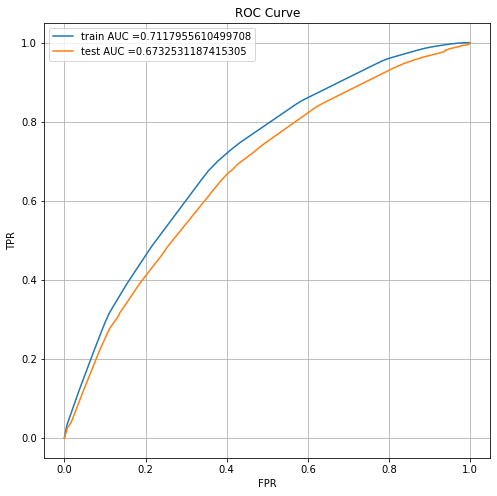

the maximum value of tpr*(1-fpr) 0.4360543998878566 for threshold 0.881


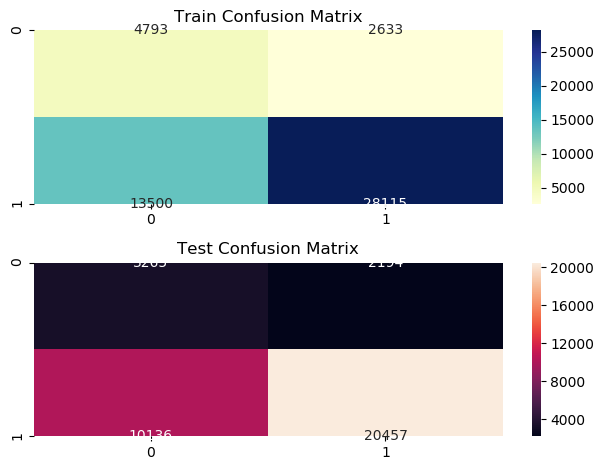

In [62]:
train_auc_tfidf, test_auc_tfidf, fpi = predict(X_tr,X_te,y_train,y_test,classifier)

#### 2.4.1.4 Generating wordcloud

100%|██████████| 2194/2194 [02:33<00:00,  5.98it/s] 


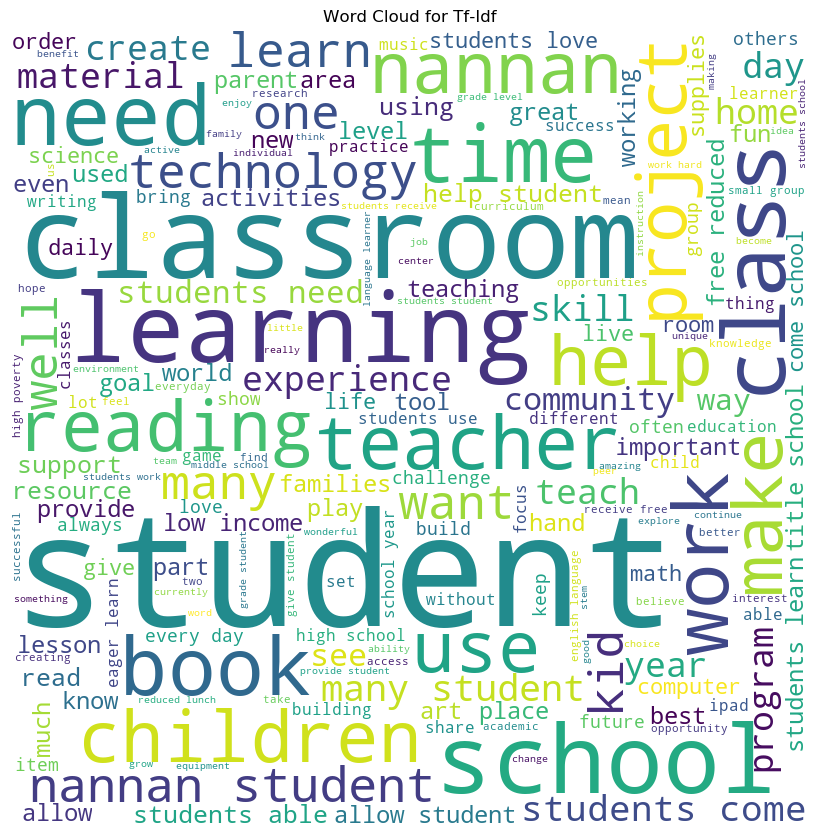

In [63]:
wordcloud(X_test, fpi, "Tf-Idf")

#### 2.4.1.5 Plotting boxplot for price for all False Positive points

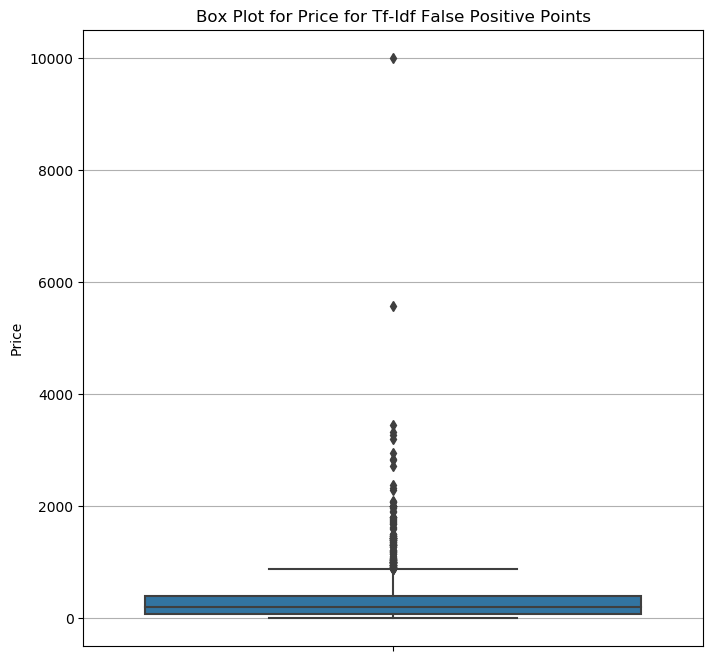

In [64]:
box_plot(fpi,X_test,"Tf-Idf")

#### 2.4.1.6 Plotting pdf for 'teacher_number_of_previously_posted_projects' for all False Positive points

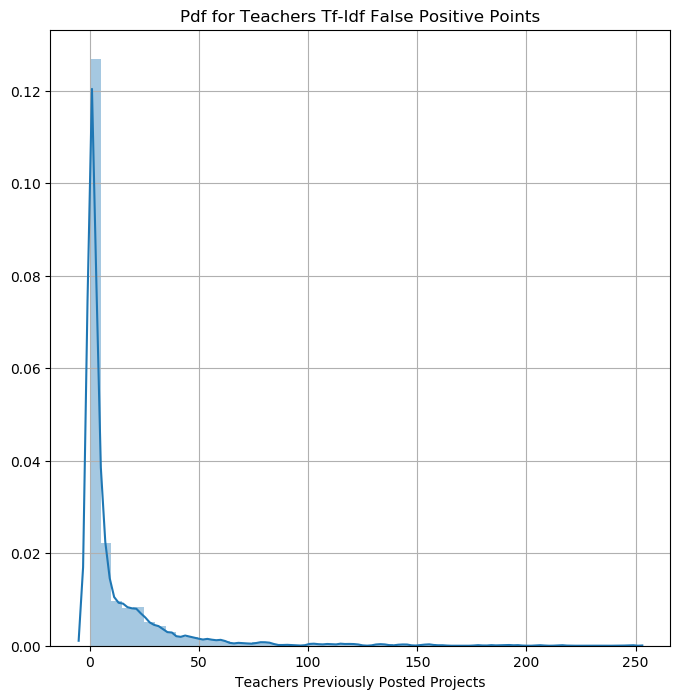

In [65]:
pdf(fpi,X_test,"Tf-Idf")

### 2.4.2 Tf-Idf W2v

In [73]:
from scipy.sparse import hstack
X_tr = hstack((X_train_cat_ohe, X_train_subcat_ohe, X_train_essay_tfidf_w2v, X_train_title_tfidf_w2v, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_std, X_train_teach_prev_std,X_train_quan_std,X_train_title_cnt_std,X_train_essay_cnt_std,X_train['pos'].values.reshape(-1,1),X_train['neg'].values.reshape(-1,1),X_train['neu'].values.reshape(-1,1),X_train['compound'].values.reshape(-1,1))).tocsr()
X_te = hstack((X_test_cat_ohe, X_test_subcat_ohe, X_test_essay_tfidf_w2v, X_test_title_tfidf_w2v, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_std, X_test_teach_prev_std,X_test_quan_std,X_test_title_cnt_std,X_test_essay_cnt_std,X_test['pos'].values.reshape(-1,1),X_test['neg'].values.reshape(-1,1),X_test['neu'].values.reshape(-1,1),X_test['compound'].values.reshape(-1,1))).tocsr()
X_cr = hstack((X_cv_cat_ohe, X_cv_subcat_ohe,  X_cv_essay_tfidf_w2v, X_cv_title_tfidf_w2v, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_std, X_cv_teach_prev_std,X_cv_quan_std,X_cv_title_cnt_std,X_cv_essay_cnt_std,X_cv['pos'].values.reshape(-1,1),X_cv['neg'].values.reshape(-1,1),X_cv['neu'].values.reshape(-1,1),X_cv['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 709) (49041,)
(24155, 709) (24155,)
(36052, 709) (36052,)


#### 2.4.2.2 Tuning Hyper Params 'max_depth' and 'min_samples_split'

In [74]:
classifier = paramtune(X_tr,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=290,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


#### 2.4.2.3 Plotting AUC Curve and confusion matrix

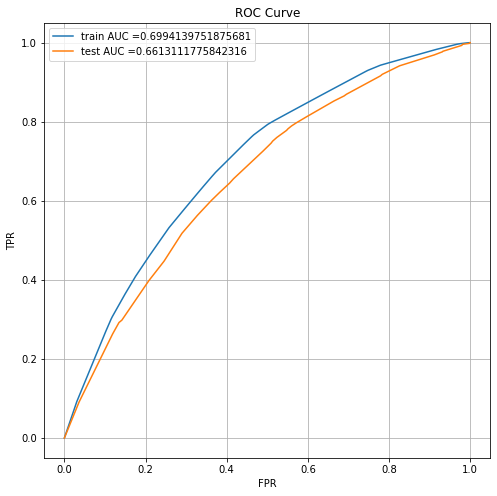

the maximum value of tpr*(1-fpr) 0.421647255200812 for threshold 0.867


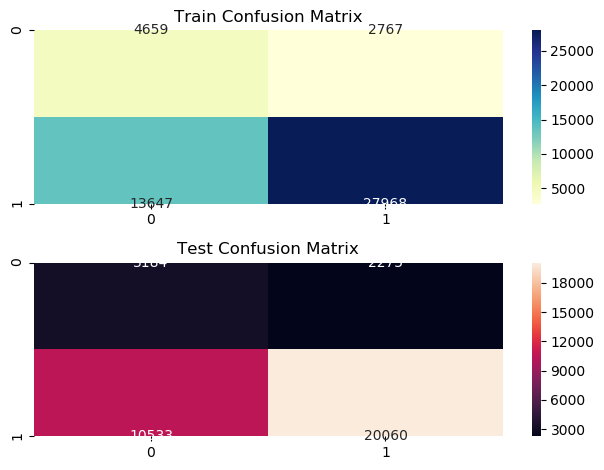

In [62]:
train_auc_tfidf_w2v, test_auc_tfidf_w2v, fpi = predict(X_tr,X_te,y_train,y_test,classifier)

#### 2.4.2.4 Generating wordcloud

100%|██████████████████████████████████████████████████████████████████████████████| 2275/2275 [02:56<00:00,  5.72it/s]


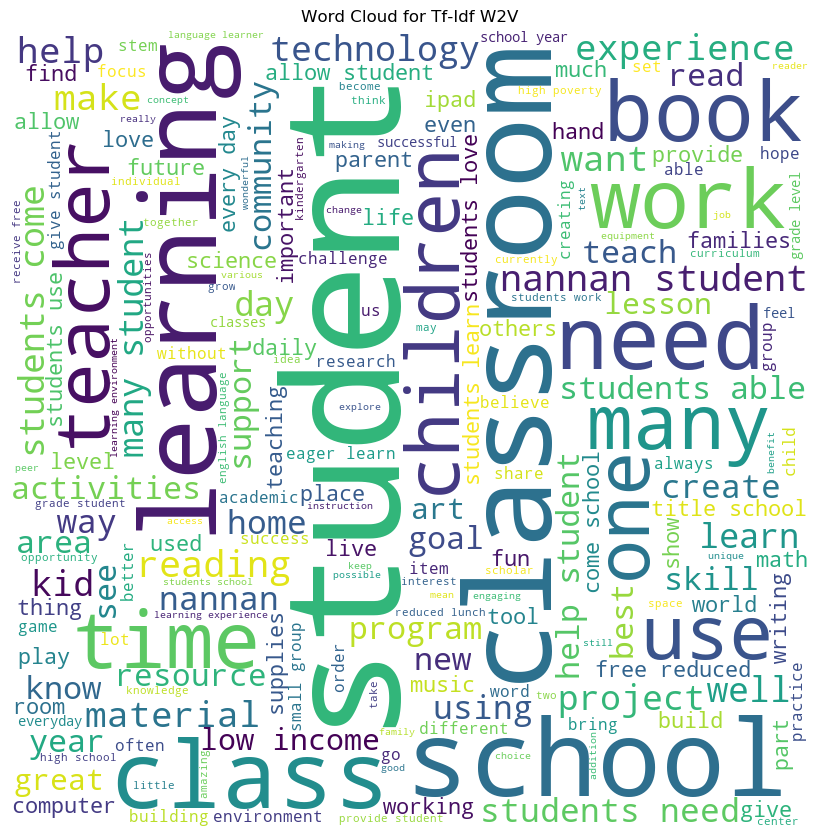

In [63]:
wordcloud(X_test, fpi, "Tf-Idf W2V")

#### 2.4.2.5 Plotting boxplot for price for all False Positive points

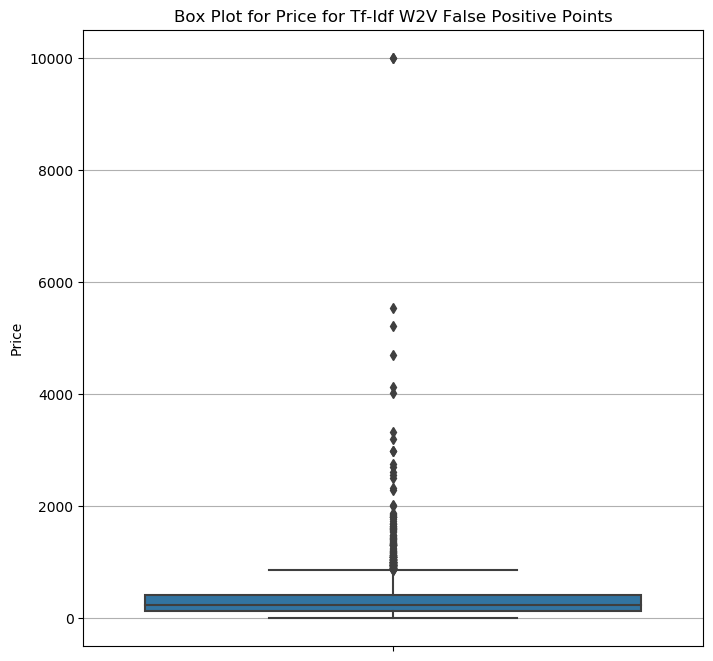

In [64]:
box_plot(fpi,X_test,"Tf-Idf W2V")

#### 2.4.2.6 Plotting pdf for 'teacher_number_of_previously_posted_projects' for all False Positive points

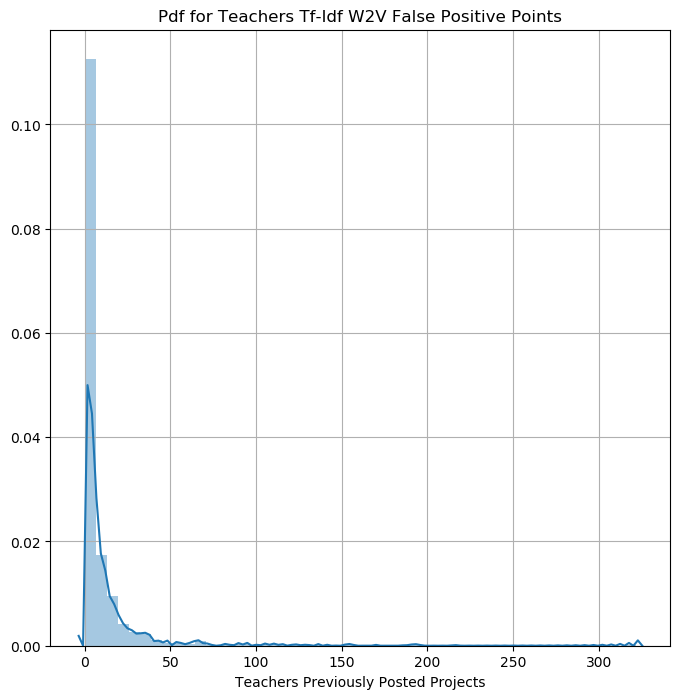

In [65]:
pdf(fpi,X_test,"Tf-Idf W2V")

<h2>2.5 Getting top features using `feature_importances_`</h2>

In [66]:
dt = DecisionTreeClassifier(max_depth = None)
parameters = {'min_samples_split':[400,450,480,500,530,550]}
clf = GridSearchCV(estimator=dt,param_grid=parameters,scoring='roc_auc',n_jobs=-1)
clf.fit(X_tr,y_train)

cv_result = clf.cv_results_
    
print(clf.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=550,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [67]:
## https://stackoverflow.com/questions/4588628/find-indices-of-elements-equal-to-zero-in-a-numpy-array

clf.best_estimator_.fit(X_tr,y_train)
t = clf.best_estimator_.feature_importances_
idx = np.where(t != 0)[0]
len(idx)

405

In [68]:
idx

array([ 12,  16,  21,  25,  32,  36,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  53,  54,  55,  56,  58,  59,  61,  64,
        66,  67,  68,  69,  70,  75,  77,  78,  79,  80,  81,  82,  83,
        85,  86,  87,  90,  92,  94,  95,  96,  97,  98, 100, 105, 106,
       109, 111, 112, 113, 114, 115, 117, 118, 120, 121, 122, 126, 129,
       131, 134, 135, 137, 138, 139, 141, 142, 143, 144, 146, 148, 150,
       151, 152, 155, 157, 159, 160, 161, 163, 164, 165, 166, 167, 168,
       169, 171, 173, 174, 177, 178, 179, 181, 182, 184, 185, 186, 188,
       190, 191, 192, 193, 194, 197, 198, 199, 202, 204, 205, 208, 209,
       210, 213, 214, 215, 217, 218, 219, 220, 223, 224, 226, 227, 229,
       231, 234, 235, 236, 237, 239, 241, 243, 244, 246, 249, 251, 253,
       256, 257, 258, 260, 261, 262, 263, 266, 271, 273, 274, 275, 276,
       279, 280, 281, 283, 284, 285, 286, 287, 290, 291, 293, 295, 296,
       298, 301, 305, 307, 308, 309, 310, 313, 318, 319, 321, 32

In [69]:
X_te.shape

(36052, 709)

In [70]:
X_tr = X_tr[:, idx]
X_te = X_te[:, idx]
X_cr = X_cr[:, idx]

#### 2.5.1 HyperParameter Tuning for LR

In [73]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#al = [ 0.005, 0.01, 0.05, 0.08, 0.]

C = [10**-4,10**-3, 10**-2,10**-1,0.5, 10**0,10**1, 10**2]

train_auc = []
cv_auc = []
diff = []

for i in tqdm(C):
    lr = LogisticRegression(C=i, penalty='l1',class_weight='balanced')
    lr.fit(X_tr,y_train)
    
#Considering the probability of belonging to a class as predict_proba returns for both classes so ignoring one, as the other is 1 - other
# Also if considered for not belonging to a class then the AUC vs ALpha curve will just invert in shape (1- previous auc scores )
    y_train_pred = lr.predict_proba(X_tr)[:,1]
    y_cv_pred = lr.predict_proba(X_cr)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    diff.append(roc_auc_score(y_train,y_train_pred) - roc_auc_score(y_cv,y_cv_pred))


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [47:17<00:00, 581.17s/it]


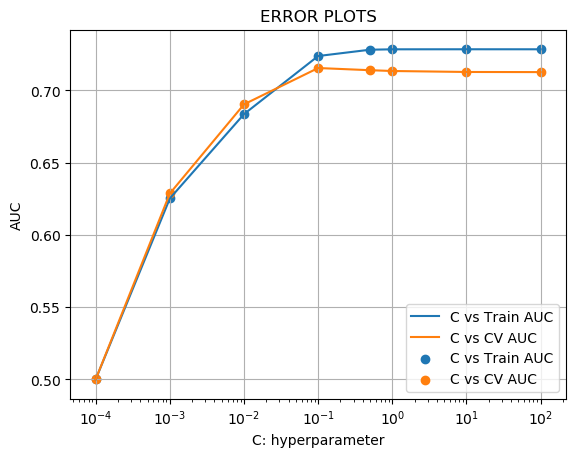

In [74]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.semilogx(C,train_auc,label = "C vs Train AUC")
plt.semilogx(C,cv_auc,label = "C vs CV AUC")

plt.scatter(C,train_auc,label = "C vs Train AUC")
plt.scatter(C,cv_auc,label = "C vs CV AUC")

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### 2.5.2 Applying LR 

In [75]:
C = 0.1

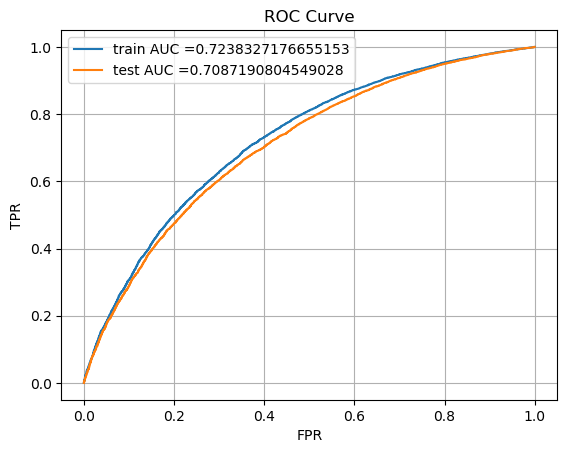

In [76]:
lr = LogisticRegression(C=C, penalty='l1',class_weight='balanced')
lr.fit(X_tr,y_train)

y_train_pred = lr.predict_proba(X_tr)[:,1]  
y_test_pred = lr.predict_proba(X_te)[:,1]

train_fpr_bow, train_tpr_bow, tr_the_bow = roc_curve(y_train, y_train_pred)
test_fpr_bow, test_tpr_bow,te_the_bow = roc_curve(y_test,y_test_pred)

plt.style.use('default')

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [77]:

#### 2.4.1.4 Predicting with best alpha and t

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

#cite:
# http://seaborn.pydata.org/generated/seaborn.heatmap.html -- Heat maps
# https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib -- tight layout for spacing

In [78]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_the_bow, train_fpr_bow, train_tpr_bow)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.4463049333341401 for threshold 0.479
Train confusion matrix
[[ 4803  2623]
 [12899 28716]]
Test confusion matrix
[[ 3421  2038]
 [ 9762 20831]]


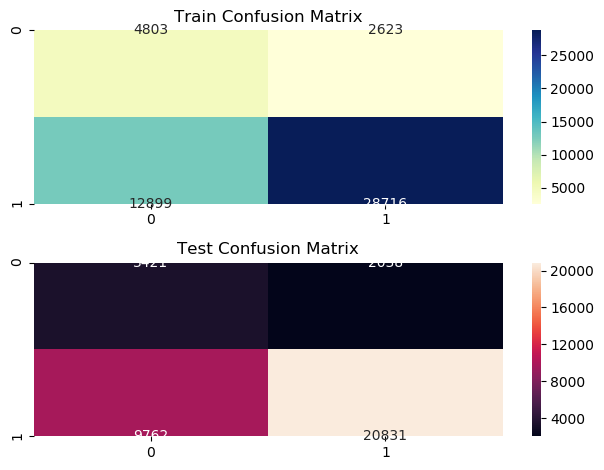

In [79]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_title('Train Confusion Matrix')
ax2.set_title('Test Confusion Matrix')
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True ,fmt = 'd', ax = ax1,cmap="YlGnBu")
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True ,fmt = 'd', ax= ax2)# #annot=True to annotate cells
fig.tight_layout()

<h1>3. Summary</h1>

In [2]:
from prettytable import PrettyTable
pt = PrettyTable(["Model", "Train AUC", "Test AUC","max_depth/C","min_samples_split/penalty"])
pt.add_row(["Tf-Idf", train_auc_tfidf, test_auc_tfidf, 8,300])
pt.add_row(["TfIdf W2V", train_auc_tfidf_w2v, test_auc_tfidf_w2v, 6,290])
pt.add_row(["Logistic Regression", auc(train_fpr_bow, train_tpr_bow), auc(test_fpr_bow, test_tpr_bow), 0.1,"l1"])

print(pt)

+---------------------+--------------------+--------------------+-------------+---------------------------+
|        Model        |     Train AUC      |      Test AUC      | max_depth/C | min_samples_split/penalty |
+---------------------+--------------------+--------------------+-------------+---------------------------+
|        Tf-Idf       | 0.7140137012556492 | 0.6682300864093952 |      8      |            300            |
|      TfIdf W2V      | 0.6994139751875681 | 0.6613111775842316 |      6      |            290            |
| Logistic Regression | 0.7238327176655153 | 0.7087190804549028 |     0.1     |             l1            |
+---------------------+--------------------+--------------------+-------------+---------------------------+


1. We see that the Test AUC for both Tf-Idf and Tf-Idf W2V are similar.
2. After keeping the features from Tf-Idf W2V with non zero feature importance and then applying Logistic Regession on those really makes a difference. The train and test AUC both are maximum for Logistic Regression.